# Aug 24, 2025: check if chains have converged

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.stats import gaussian_kde
from multiprocessing import Pool
import glob
from numba import jit
# import arviz as az
import re

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

# import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

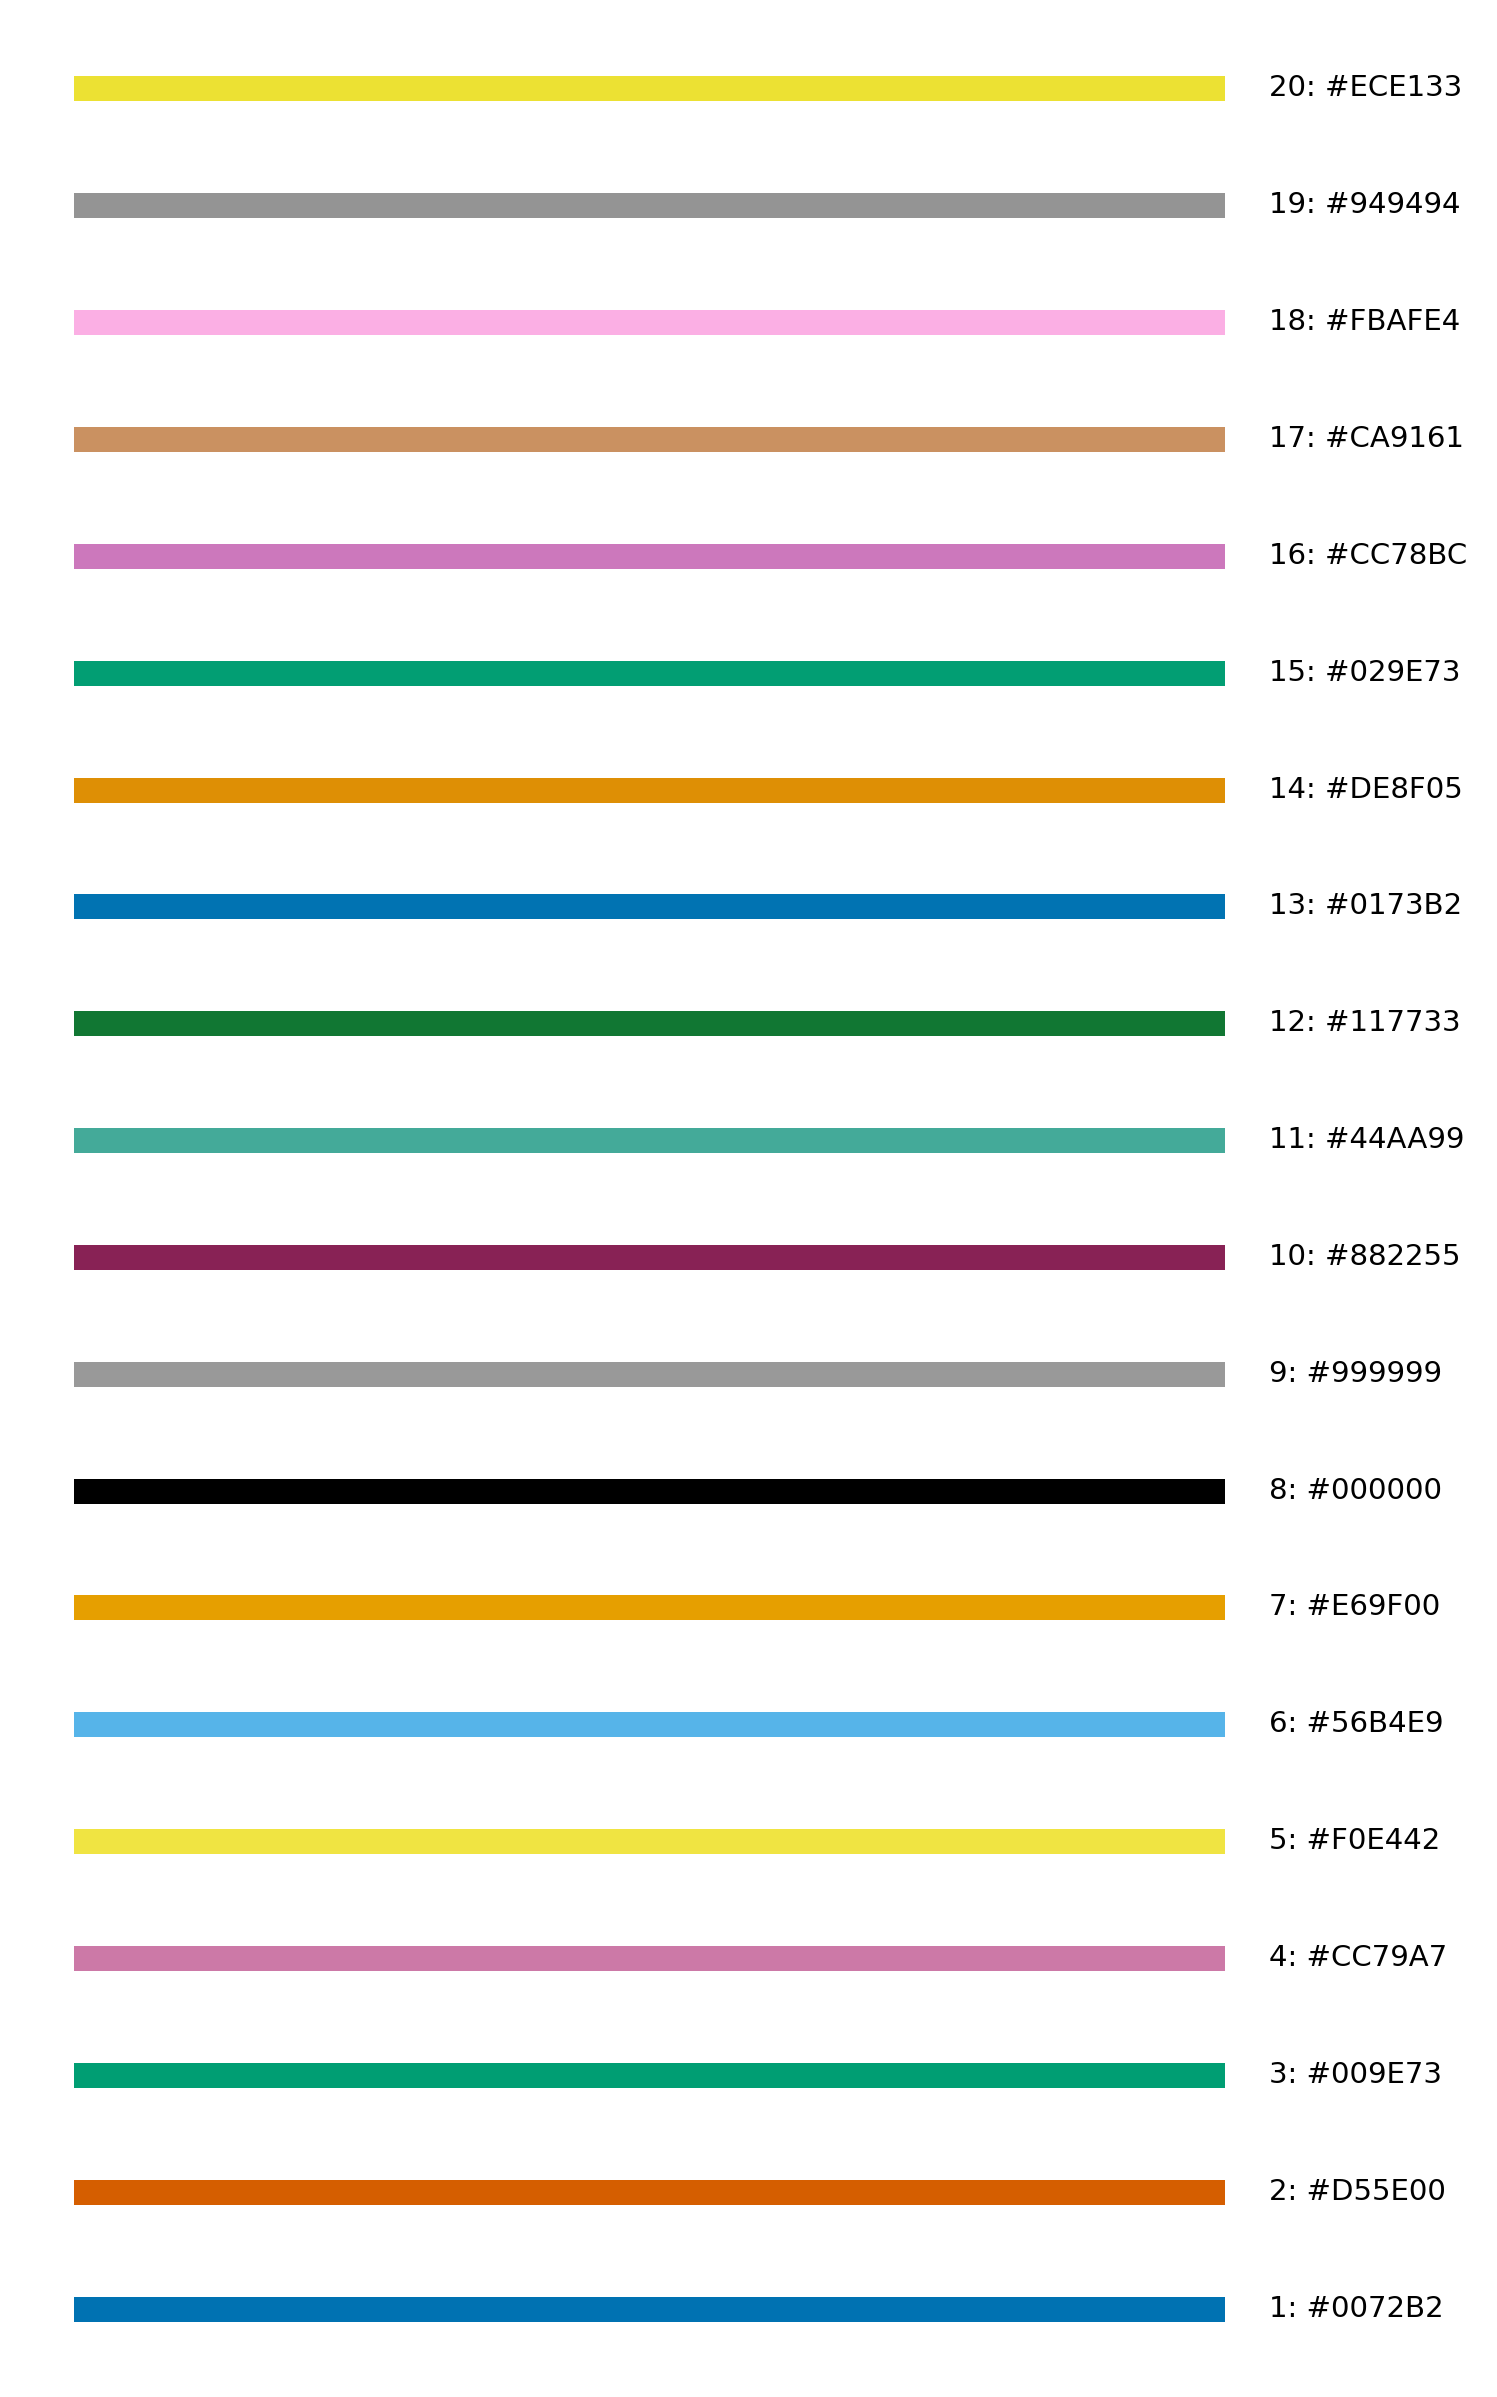

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.source = 'allen' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #334 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics_insets'
os.system(f'mkdir -p {DIAG_path}')

0

In [8]:
SBM_path

'/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits'

In [9]:
args.dc, args.sbm = True, 'h'
args.force_niter = 3000 if args.sbm in ['o'] else 100000 #40000 
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.2 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-dc-h'

In [10]:
def collect_sbm_files(args, sbm_files):
    sbms_df = []
    for file in tqdm(sbm_files):
        try:
            with open(file, 'rb') as f:
                [bs, Bs, Bes, dls] = pickle.load(f)
            
            fs = file.split('/')
            sub = '-'.join([s for s in fs if 'sub-' in s][0].split('-')[1:])
            sbm = [s for s in fs if 'sbm-' in s][0]
            B = [s for s in fs if 'B-' in s][0].split('-')[-1]

            Bes = Bes[0] if args.sbm in ['h'] else Bes
            
            row = pd.DataFrame(dict(
                sub=[sub],
                sbm=[sbm],
                chain=[B],
                Bes=[dls], #dls, Bes
            ))
            sbms_df += [row]
        # break
        except:
            pass
    sbms_df = pd.concat(sbms_df).reset_index(drop=True)
    return sbms_df

sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/*/desc-partitions.pkl', recursive=True))
# sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/*/desc-Bes.pkl', recursive=True))
sbms_df = collect_sbm_files(args, sbm_files)

100%|██████████| 45/45 [12:40<00:00, 16.89s/it]


In [11]:
len(sbms_df.iloc[0]['Bes']) + 1

100000

In [12]:
replacement_dict = {val: f'{i+1}' for i, val in enumerate(sbms_df['chain'].unique())}
sbms_df['chain'] = sbms_df['chain'].replace(replacement_dict)

In [13]:
sbms_df.head(n=10)

,sub,sbm,chain,Bes
0,SLC01_task-rest,sbm-dc-h,1,"[6188.716431997409, 6184.816048996267, 6190.64..."
1,SLC01_task-rest,sbm-dc-h,2,"[6221.43876972883, 6200.845716127272, 6184.794..."
2,SLC01_task-rest,sbm-dc-h,3,"[6180.072462346805, 6171.239868779321, 6173.89..."
3,SLC01_task-rest,sbm-dc-h,4,"[6213.100290794409, 6211.097879509583, 6200.56..."
4,SLC01_task-rest,sbm-dc-h,5,"[6209.299256373217, 6206.199045445374, 6193.11..."
5,SLC03_task-rest,sbm-dc-h,1,"[6129.658641301173, 6121.445017348495, 6130.80..."
6,SLC03_task-rest,sbm-dc-h,2,"[6167.218942819359, 6157.478766268361, 6141.80..."
7,SLC03_task-rest,sbm-dc-h,3,"[6153.010891988969, 6144.6096688536845, 6131.9..."
8,SLC03_task-rest,sbm-dc-h,4,"[6139.499540684321, 6117.781560141551, 6104.95..."
9,SLC03_task-rest,sbm-dc-h,5,"[6152.921809787447, 6150.609729366009, 6152.32..."


In [14]:
def KSD(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    
    ksds_df = []
    for idx1, idx2 in (combinations(chain_idxs, 2)):
        Bes_ch1 = chains_df.iloc[idx1]['Bes']
        Bes_ch2 = chains_df.iloc[idx2]['Bes']
        Ds = []
        ts = np.arange(10, args.force_niter, args.delta)
        for t in ts:
            res = stats.ks_2samp(Bes_ch1[:t], Bes_ch2[:t])
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': ts,
            'D': Ds,
        })
        ksds_df.append(df)
    ksds_df = pd.concat(ksds_df).reset_index(drop=True)
    return ksds_df

def plot_KSD_inset(inset_ax, args, chains_df, ksds_df):
    """
    Plot KSD convergence curves into a given inset axis.
    Returns True if model is converged by midpoint criterion.
    """
    from itertools import combinations
    import numpy as np

    chain_idxs = chains_df.index.to_list()
    Ds = []

    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksds_df[
            (ksds_df['ch1'] == idx1) &
            (ksds_df['ch2'] == idx2)
        ][['t', 'D']].to_numpy()

        Ds.append(t_D[:, 1])
        inset_ax.plot(
            t_D[:, 0],
            t_D[:, 1],
            color=CUD_COLORS[0],
            alpha=0.5,
            linewidth=0.75,
        )

    Ds = np.stack(Ds, axis=-1)
    t = t_D[:, 0]
    inset_ax.plot(t, np.median(Ds, axis=-1), color=CUD_COLORS[1], linewidth=1.0)
    inset_ax.plot(t, args.epsilon * np.ones_like(t), color="#999999", linestyle="--", linewidth=0.8)
    inset_ax.axvline(x=args.num_draws, color="#CA9161", linestyle="--", linewidth=0.8)

    # Style
    inset_ax.set_ylabel("KSD", fontsize=6, labelpad=-6)
    inset_ax.set_xlabel("MCMC steps", fontsize=6, labelpad=-6)
    xmin, xmax = inset_ax.get_xlim()
    xticks = np.linspace(xmin, xmax, 5)
    inset_ax.set_xticks([np.ceil(xt) for xt in xticks], labels=['0', '', '', '', '10'])
    inset_ax.set_yticks([0, 0.5, 1], [0, '', 1])
    inset_ax.tick_params(labelsize=6, width=0.5, length=2)
    for spine in inset_ax.spines.values():
        spine.set_linewidth(0.5)
    inset_ax.grid(alpha=0.3)
    # Return convergence status
    T = Ds.shape[0]
    return np.all(Ds[T//2:, :] < args.epsilon), np.mean(Ds, axis=-1)

In [15]:
def plot_density_overlap(ax, args, chains_df, label='None', legend=False):
    df = chains_df.explode('Bes_conv')
    
    sns.kdeplot(
        data=df, ax=ax,
        x='Bes_conv',
        hue='chain',
        palette=CUD_COLORS,
        fill=True,
        alpha=0.1,
        legend=False,
    )

    ax.set_title(f'{label}', fontsize=7, pad=2)
    ax.set_xlabel('description length', fontsize=7,)# labelpad=2)
    ax.set_ylabel('density', fontsize=7)
    ax.set_yticklabels([])  # clean y-axis for panel plots
    ax.tick_params(axis='y', which='major', length=2.5, width=0.5)
    ax.grid(alpha=0.15, linewidth=0.3)

    # Rounded xticks
    xmin, xmax = ax.get_xlim()
    xticks = np.linspace(xmin, xmax, 5)
    ax.set_xticks(np.round(xticks, 1))
    ax.tick_params(axis='x', which='major', length=2.5, width=0.5)

    return None

In [16]:
def create_diagnostics_plots(args, sbms_df):
    ncols = 1
    nrows = len(sbms_df['sub'].unique())

    a = 20 / 9 # 3.0
    b = a * 4 / 7 # 2.3

    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, 
        figsize=(a*ncols, b*nrows), # inches
        sharex=False, sharey=False
    )
    # fig.tight_layout(h_pad=0, w_pad=0)

    mean_ksds = []

    for idx, (sub, group) in tqdm(enumerate(sbms_df.groupby(by=['sub']))):
        sub = sub[0]
        group = group.reset_index(drop=True)
        group['Bes_conv'] = group['Bes'].apply(lambda x: x[-args.num_draws:])
        display(group)

        ax = axs[idx, 1] if ncols > 1 else axs[idx]
        
        legend = False # idx < 1
        plot_density_overlap(ax, args, group, label=f'sub-{sub}', legend=legend)

        ksds_df = KSD(args, group)
        iax = inset_axes(ax, width='45%', height='45%', loc='upper right', borderpad=0.5)
        converged, mean_ksd = plot_KSD_inset(iax, args, group, ksds_df)
        mean_ksds.append(mean_ksd)
        display(converged)

    # break
    ref_pos = axs[0].get_position()
    return fig, np.stack(mean_ksds, axis=0), ref_pos

0it [00:00, ?it/s]

,sub,sbm,chain,Bes,Bes_conv
0,SLC01_task-rest,sbm-dc-h,1,"[6188.716431997409, 6184.816048996267, 6190.64...","[6144.960675041207, 6142.720563476653, 6142.64..."
1,SLC01_task-rest,sbm-dc-h,2,"[6221.43876972883, 6200.845716127272, 6184.794...","[6138.482605953288, 6136.945903023403, 6139.36..."
2,SLC01_task-rest,sbm-dc-h,3,"[6180.072462346805, 6171.239868779321, 6173.89...","[6140.367496650317, 6139.3600278833255, 6138.8..."
3,SLC01_task-rest,sbm-dc-h,4,"[6213.100290794409, 6211.097879509583, 6200.56...","[6151.642056297479, 6151.052073719089, 6142.18..."
4,SLC01_task-rest,sbm-dc-h,5,"[6209.299256373217, 6206.199045445374, 6193.11...","[6140.902162364059, 6144.15886655037, 6142.033..."


True

1it [00:34, 34.65s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC03_task-rest,sbm-dc-h,1,"[6129.658641301173, 6121.445017348495, 6130.80...","[6094.170727962909, 6094.92169368718, 6098.731..."
1,SLC03_task-rest,sbm-dc-h,2,"[6167.218942819359, 6157.478766268361, 6141.80...","[6100.615732351364, 6101.594445655864, 6108.46..."
2,SLC03_task-rest,sbm-dc-h,3,"[6153.010891988969, 6144.6096688536845, 6131.9...","[6104.106053537945, 6099.728728918479, 6102.36..."
3,SLC03_task-rest,sbm-dc-h,4,"[6139.499540684321, 6117.781560141551, 6104.95...","[6092.688644521011, 6092.410315168589, 6091.70..."
4,SLC03_task-rest,sbm-dc-h,5,"[6152.921809787447, 6150.609729366009, 6152.32...","[6094.373549602394, 6102.157926633246, 6092.20..."


True

2it [01:06, 32.74s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC04_task-rest,sbm-dc-h,1,"[6147.956053464028, 6152.9935420479915, 6151.4...","[6105.558989122801, 6100.146657790069, 6103.63..."
1,SLC04_task-rest,sbm-dc-h,2,"[6147.6602164610995, 6148.768281344874, 6142.6...","[6104.247162391164, 6103.842197780257, 6101.68..."
2,SLC04_task-rest,sbm-dc-h,3,"[6188.63393384695, 6181.987310858677, 6173.768...","[6099.516486779798, 6091.506965798506, 6098.15..."
3,SLC04_task-rest,sbm-dc-h,4,"[6143.460417906359, 6146.776574928817, 6140.77...","[6115.187679933954, 6116.095349814749, 6113.15..."
4,SLC04_task-rest,sbm-dc-h,5,"[6148.776920403505, 6158.781690511827, 6153.40...","[6100.020368346866, 6097.546678731508, 6097.68..."


True

3it [01:38, 32.81s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC05_task-rest,sbm-dc-h,1,"[6394.138846110763, 6385.175601416746, 6383.85...","[6363.101763559026, 6361.7324830012485, 6361.4..."
1,SLC05_task-rest,sbm-dc-h,2,"[6394.855474995887, 6386.366326190988, 6387.22...","[6371.578845688324, 6369.980147409563, 6363.18..."
2,SLC05_task-rest,sbm-dc-h,3,"[6382.597908315849, 6378.389678319875, 6384.31...","[6362.545374717795, 6359.976899336895, 6355.97..."
3,SLC05_task-rest,sbm-dc-h,4,"[6386.291668287123, 6371.342608975156, 6375.75...","[6366.199961500074, 6362.776398870452, 6357.50..."
4,SLC05_task-rest,sbm-dc-h,5,"[6396.538349573879, 6384.018518914801, 6379.26...","[6374.125618849351, 6374.447624048246, 6376.82..."


True

4it [02:12, 33.02s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC06_task-rest,sbm-dc-h,1,"[6003.574260847153, 6003.087257641427, 5999.67...","[5971.2792631539805, 5968.0201795412195, 5975...."
1,SLC06_task-rest,sbm-dc-h,2,"[5986.090777332684, 5987.468003946384, 5989.23...","[5964.146982295718, 5950.837717586901, 5964.17..."
2,SLC06_task-rest,sbm-dc-h,3,"[6011.129627599458, 6003.525644360307, 6002.46...","[5966.963481284579, 5963.32545370376, 5957.209..."
3,SLC06_task-rest,sbm-dc-h,4,"[5969.768566903496, 5969.444122997412, 5978.43...","[5966.529656635768, 5970.650880902048, 5961.41..."
4,SLC06_task-rest,sbm-dc-h,5,"[5969.698680820088, 5970.813335186042, 5973.19...","[5964.2288815283455, 5966.877520590332, 5967.6..."


True

5it [02:41, 31.56s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC07_task-rest,sbm-dc-h,1,"[6076.671980070897, 6073.450514801995, 6064.79...","[6055.339624565705, 6034.615049157099, 6044.77..."
1,SLC07_task-rest,sbm-dc-h,2,"[6067.7000004966985, 6057.719579444304, 6064.6...","[6048.740749024904, 6042.047882502854, 6035.24..."
2,SLC07_task-rest,sbm-dc-h,3,"[6082.86174847821, 6077.954818080208, 6065.068...","[6035.404101234522, 6037.943322621351, 6037.73..."
3,SLC07_task-rest,sbm-dc-h,4,"[6087.607631301054, 6084.8673649582925, 6085.4...","[6044.960378090967, 6033.693396378783, 6039.37..."
4,SLC07_task-rest,sbm-dc-h,5,"[6088.82460974854, 6083.245073424518, 6084.989...","[6048.349230704486, 6050.842766369522, 6039.48..."


True

6it [03:11, 31.24s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC08_task-rest,sbm-dc-h,1,"[6195.202721935953, 6193.216427165872, 6184.58...","[6146.734771809981, 6146.40773080906, 6139.445..."
1,SLC08_task-rest,sbm-dc-h,2,"[6195.509809133533, 6173.008976752828, 6179.70...","[6151.031460952302, 6148.400892877161, 6148.42..."
2,SLC08_task-rest,sbm-dc-h,3,"[6192.654095170674, 6178.1899904859765, 6197.9...","[6148.430835276649, 6151.113878018782, 6155.66..."
3,SLC08_task-rest,sbm-dc-h,4,"[6222.361831338168, 6211.875933736937, 6208.79...","[6144.180256035785, 6144.097476534193, 6145.56..."
4,SLC08_task-rest,sbm-dc-h,5,"[6189.82455289067, 6198.318896225471, 6176.816...","[6151.372341002802, 6148.128331353523, 6142.83..."


True

7it [03:46, 32.33s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC09_task-rest,sbm-dc-h,1,"[6323.277407409898, 6309.227694207841, 6307.31...","[6250.053674686532, 6252.529998335747, 6256.99..."
1,SLC09_task-rest,sbm-dc-h,2,"[6310.30735433266, 6299.209774155032, 6280.885...","[6247.011677290515, 6247.611307882505, 6259.02..."
2,SLC09_task-rest,sbm-dc-h,3,"[6271.670397636842, 6270.645689878276, 6275.98...","[6243.80588571829, 6244.495627150122, 6248.568..."
3,SLC09_task-rest,sbm-dc-h,4,"[6322.312782870151, 6295.467361182452, 6298.01...","[6249.285968243395, 6244.110412959652, 6243.35..."
4,SLC09_task-rest,sbm-dc-h,5,"[6304.463640549769, 6301.817775867535, 6290.49...","[6254.197606831439, 6250.609642134296, 6244.49..."


True

8it [04:21, 33.29s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC10_task-rest,sbm-dc-h,1,"[6230.282074245946, 6223.789438865308, 6225.86...","[6203.179338405758, 6195.138176026092, 6194.63..."
1,SLC10_task-rest,sbm-dc-h,2,"[6231.7318006273035, 6232.431676037575, 6227.1...","[6190.106410455829, 6192.317931834842, 6196.03..."
2,SLC10_task-rest,sbm-dc-h,3,"[6235.492767253862, 6228.192478370699, 6220.69...","[6190.456321688248, 6199.170023749052, 6193.58..."
3,SLC10_task-rest,sbm-dc-h,4,"[6227.735469447187, 6209.729592296693, 6198.95...","[6192.173815819577, 6193.666119905377, 6193.91..."
4,SLC10_task-rest,sbm-dc-h,5,"[6222.23215274578, 6226.176171743177, 6230.892...","[6193.989536634773, 6198.100119224701, 6192.56..."


True

9it [04:54, 32.77s/it]


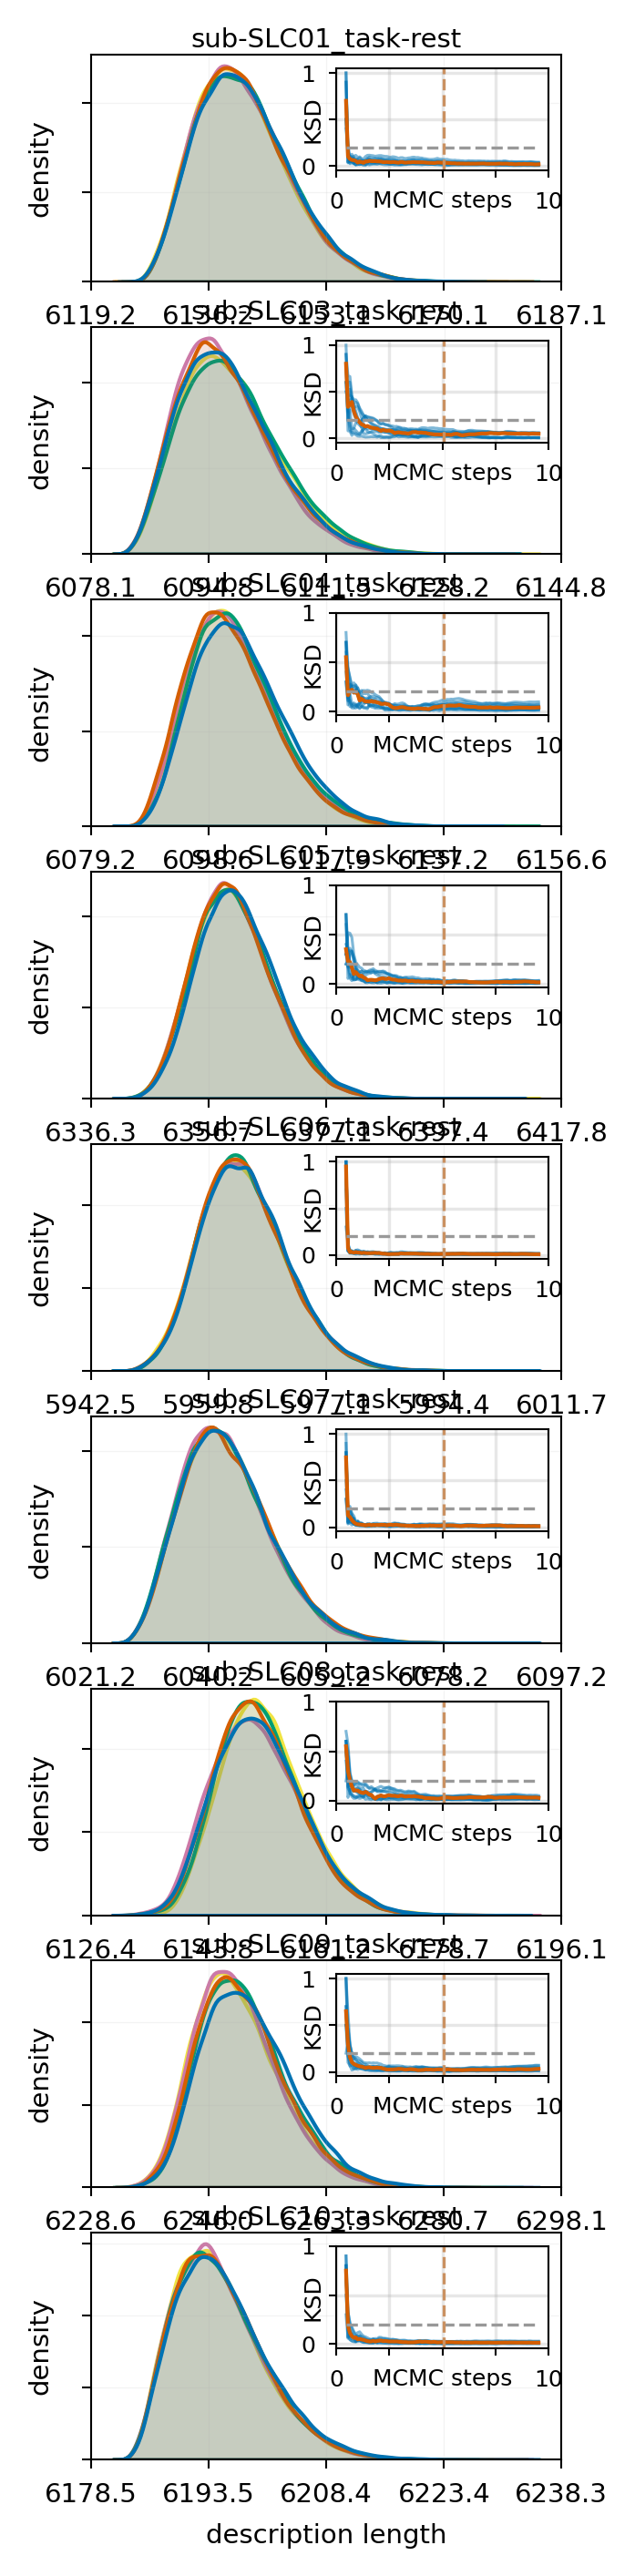

In [17]:
figfile = f'{DIAG_path}/{SBM}_desc-diagnostics.png'
if os.path.exists(figfile):
    display(Image(figfile))
else:
    fig, mean_ksds, ref_pos = create_diagnostics_plots(args, sbms_df)

In [18]:
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.png', bbox_inches='tight', transparent=True)
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.svg', bbox_inches='tight', transparent=True)

In [19]:
def bootstrap_median_ci(data, n_bootstrap=1000, ci=95):
    """
    data: array of shape (n_animals, n_steps)
    Returns lower and upper CI bounds for the median across animals, per timepoint.
    """
    n_animals, n_steps = data.shape
    ci_bounds = np.empty((2, n_steps))

    for t in range(n_steps):
        samples = data[:, t]
        medians = np.array([
            np.median(np.random.choice(samples, size=n_animals, replace=True))
            for _ in range(n_bootstrap)
        ])
        lower = np.percentile(medians, (100 - ci) / 2)
        upper = np.percentile(medians, 100 - (100 - ci) / 2)
        ci_bounds[:, t] = [lower, upper]

    return ci_bounds

def plot_group_level_summary(args, mean_ksds):
    ncols = 1
    nrows = 1

    a = 20 / 9  # ~2.22
    b = a * 3.5 / 7  # ~1.27

    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(a * ncols, b * nrows),
        sharex=False, sharey=False
    )

    ax = axs
    t = np.arange(mean_ksds.shape[0])
    mid_point = t[t.shape[0]//2]

    # plot the curves per animal
    ax.plot(t, mean_ksds[:, 0], color=CUD_COLORS[0], linewidth=0.75, alpha=0.5, label='animal')
    ax.plot(t, mean_ksds[:, 1:], color=CUD_COLORS[0], linewidth=0.75, alpha=0.5)

    # Compute median, and MAD across animals
    median_curve = np.median(mean_ksds, axis=1)
    # mad_curve = np.median(np.abs(mean_ksds - median_curve[:, None]), axis=1)
    ci_bounds = bootstrap_median_ci(mean_ksds.T, n_bootstrap=1000, ci=95)

    # Plot median with MAD band
    ax.plot(t, median_curve, color=CUD_COLORS[1], linewidth=1.0, label='median')
    ax.fill_between(
        t,
        ci_bounds[0],
        ci_bounds[1],
        color=CUD_COLORS[1],
        alpha=0.3,
        label='95% CI'
    )

    # Convergence quality zones
    # ax.fill_between(t, 0.0, 0.2, color='#009E73', alpha=0.15, label='Acceptable')
    # ax.fill_between(t, 0.2, 0.4, color='#F0E442', alpha=0.15, label='Caution')
    # ax.fill_between(t, 0.4, 1.0, color='#882255', alpha=0.15, label='Severe')
    ax.plot(t, 0.2 * np.ones_like(t), color='#009E73', linewidth=0.8, linestyle='--', label='acceptable threshold (0.2)')
    # ax.plot(t, 0.4 * np.ones_like(t), color='#999999', linewidth=0.8, linestyle='--')
    ax.axvline(x=mid_point, color="#CA9161", linestyle="--", linewidth=0.8, alpha=1.0, label='chain mid-point')

    # Axis settings
    ax.set_title(f'{SBM}', fontsize=7, pad=2)
    ax.set_ylabel('KSD', fontsize=7)
    ax.set_xlabel('MCMC steps', fontsize=7)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels(['0', '0.5', '1'])
    ax.set_ylim([0.0, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=7, length=2.5, width=0.5)
    ax.grid(alpha=0.15, linewidth=0.3)

    # Optional legend
    ax.legend(fontsize=5, frameon=True, loc='upper right')

    # fig.tight_layout()

    return fig


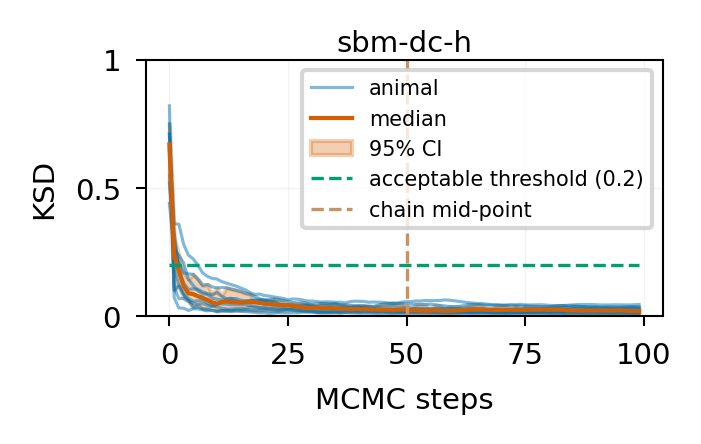

In [20]:
fig_group = plot_group_level_summary(args, mean_ksds.T)

In [21]:
fig_group.savefig(f'{DIAG_path}/{SBM}_desc-group_summary.png', bbox_inches='tight', transparent=True)
fig_group.savefig(f'{DIAG_path}/{SBM}_desc-group_summary.svg', bbox_inches='tight', transparent=True)